This dataset offers information about the rising risk of digital financial fraud. The most significant technological hurdle to predicting fraud is the extraordinarily unequal distribution of positive/negative classifications. The likelihood of errors in the data's description is another hindrance to its use. The goal of this inquiry is to address both of these issues by first investigating and cleaning the data, then applying a suitable machine-learning approach to deal with the skewness. An optimal solution based on feature engineering and extreme gradient-boosted decision trees has a prediction value of 0.997, according to the area under the precision-recall curve. Importantly, these results were obtained without the use of a fictitious data balance, allowing this strategy to be used to real-world applications.

# Import Libraries

In [22]:
!pip install lazypredict

In [23]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import time
# sklearn 
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
sns.set_style("dark")  # darkgrid, whitegrid, dark, white, ticks

# Checking Data

## Features

**step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount** - amount of the transaction in local currency.

**nameOrig** - customer who started the transaction

**oldbalanceOrg** - initial balance before the transaction

**newbalanceOrig** - new balance after the transaction

**nameDest** - customer who is the recipient of the transaction

**oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [24]:
df = pd.read_csv('/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# Exploratory Data Analysis (EDA) 

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [26]:
df.describe().round(2)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6.362620e+06,6.362620e+06,6362620.00,6362620.0
mean,243.40,179861.90,833883.10,855113.67,1.100702e+06,1.224996e+06,0.00,0.0
std,142.33,603858.23,2888242.67,2924048.50,3.399180e+06,3.674129e+06,0.04,0.0
min,1.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,0.00,0.0
25%,156.00,13389.57,0.00,0.00,0.000000e+00,0.000000e+00,0.00,0.0
50%,239.00,74871.94,14208.00,0.00,1.327057e+05,2.146614e+05,0.00,0.0
75%,335.00,208721.48,107315.18,144258.41,9.430367e+05,1.111909e+06,0.00,0.0
max,743.00,92445516.64,59585040.37,49585040.37,3.560159e+08,3.561793e+08,1.00,1.0


In [27]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Fortunately, there are no null values.

In [28]:
# transactions with zero balances 
df[df.amount==0]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736447,212,CASH_OUT,0.0,C1510987794,0.0,0.0,C1696624817,0.00,0.00,1,0
3247298,250,CASH_OUT,0.0,C521393327,0.0,0.0,C480398193,0.00,0.00,1,0
3760289,279,CASH_OUT,0.0,C539112012,0.0,0.0,C1106468520,538547.63,538547.63,1,0
5563714,387,CASH_OUT,0.0,C1294472700,0.0,0.0,C1325541393,7970766.57,7970766.57,1,0
5996408,425,CASH_OUT,0.0,C832555372,0.0,0.0,C1462759334,76759.90,76759.90,1,0
5996410,425,CASH_OUT,0.0,C69493310,0.0,0.0,C719711728,2921531.34,2921531.34,1,0
6168500,554,CASH_OUT,0.0,C10965156,0.0,0.0,C1493336195,230289.66,230289.66,1,0
6205440,586,CASH_OUT,0.0,C1303719003,0.0,0.0,C900608348,1328472.86,1328472.86,1,0
6266414,617,CASH_OUT,0.0,C1971175979,0.0,0.0,C1352345416,0.00,0.00,1,0
6281483,646,CASH_OUT,0.0,C2060908932,0.0,0.0,C1587892888,0.00,0.00,1,0


In [29]:
zero_trans_df = df.loc[(df.oldbalanceDest == 0) & (df.newbalanceDest == 0) & df.amount]
fraud_zero_trans_df = zero_trans_df[df['isFraud'] == 1]
nonfraud_zero_trans_df = zero_trans_df[df['isFraud'] == 0]
#display(zero_trans_df, fraud_zero_trans_df, nonfraud_zero_trans_df)

print(f"Length of fraudulent transactions with zero \'oldBalanceDest\' & \'newBalanceDest\' although the non-zero transacted \'amount\': {len(fraud_zero_trans_df)}")
print(f"Length of genuine transactions with zero \'oldBalanceDest\' & \'newBalanceDest\' although the non-zero transacted \'amount\': {len(nonfraud_zero_trans_df)}")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


Length of fraudulent transactions with zero 'oldBalanceDest' & 'newBalanceDest' although the non-zero transacted 'amount': 4070
Length of genuine transactions with zero 'oldBalanceDest' & 'newBalanceDest' although the non-zero transacted 'amount': 2313206


We cannot impute half of the fraudulent transactions since they have 0 'oldBalanceDest' and 'newBalanceDest'.

We may swap 0 with -1 to make an appropriate machine-learning (ML) method for identifying fraud more useful.

In [30]:
df.loc[(df.oldbalanceDest == 0) & (df.newbalanceDest == 0) & df.amount, ['oldbalanceDest', 'newbalanceDest']] = - 1

## Check duplicates

In [31]:
# count number of duplicate rows
print(f"Dataset has # {len(df)-len(df.drop_duplicates())} duplicated rows")

# display duplicated rows
display(df[df.duplicated()])

# remove duplicates
#df.drop_duplicates(inplace=True)

Dataset has # 0 duplicated rows


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud


Dataset has # 0 duplicated rows.

In [32]:
for col in df.select_dtypes(include='object').columns:
    unique_items = df[col].unique()
    print(f"Columns \'{col}\' has {len(unique_items)} unique values of {len(df)}")
    print(f"{unique_items}\n")

Columns 'type' has 5 unique values of 6362620
['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN']

Columns 'nameOrig' has 6353307 unique values of 6362620
['C1231006815' 'C1666544295' 'C1305486145' ... 'C1162922333' 'C1685995037'
 'C1280323807']

Columns 'nameDest' has 2722362 unique values of 6362620
['M1979787155' 'M2044282225' 'C553264065' ... 'C1850423904' 'C1881841831'
 'C2080388513']



In [33]:
len(df), df.nameOrig.nunique() , df.nameDest.nunique(), df.step.nunique()

(6362620, 6353307, 2722362, 743)

In [34]:
df[df.isFraud==1].step.nunique(), df[df.isFraud==0].step.nunique()

(741, 423)

**step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

In [35]:
#step -> hours and days
hours = df.step // 31
day = df.step % 31


In [36]:
df.groupby(['isFlaggedFraud']).size()

isFlaggedFraud
0    6362604
1         16
dtype: int64

In [37]:
df[(df.isFlaggedFraud == 1) & (df.isFraud == 1)]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,-1.0,-1.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,-1.0,-1.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,-1.0,-1.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,-1.0,-1.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,-1.0,-1.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,-1.0,-1.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,-1.0,-1.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,-1.0,-1.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,-1.0,-1.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,-1.0,-1.0,1,1


**isFlaggedFrauda** feature only set 1 to 18 fraud row with type TRANSFER only. We can drop it.

# Create new features

**amount** - amount of the transaction in local currency.

In [38]:
df['errorBalanceOrg'] = df.amount + df.newbalanceOrig - df.oldbalanceOrg 
df['errorBalanceDest'] = df.amount + df.newbalanceDest - df.oldbalanceDest

df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'errorBalanceOrg', 'errorBalanceDest']].head(20)

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,errorBalanceOrg,errorBalanceDest
0,9839.64,170136.00,160296.36,-1.0,-1.00,0.00,9839.64
1,1864.28,21249.00,19384.72,-1.0,-1.00,0.00,1864.28
2,181.00,181.00,0.00,-1.0,-1.00,0.00,181.00
3,181.00,181.00,0.00,21182.0,0.00,0.00,-21001.00
4,11668.14,41554.00,29885.86,-1.0,-1.00,0.00,11668.14
5,7817.71,53860.00,46042.29,-1.0,-1.00,0.00,7817.71
6,7107.77,183195.00,176087.23,-1.0,-1.00,0.00,7107.77
7,7861.64,176087.23,168225.59,-1.0,-1.00,0.00,7861.64
8,4024.36,2671.00,0.00,-1.0,-1.00,1353.36,4024.36
9,5337.77,41720.00,36382.23,41898.0,40348.79,0.00,3788.56


Percentages of Fraudulent and Legitimate Transactions: isFraud
0    6354407
1       8213
dtype: int64


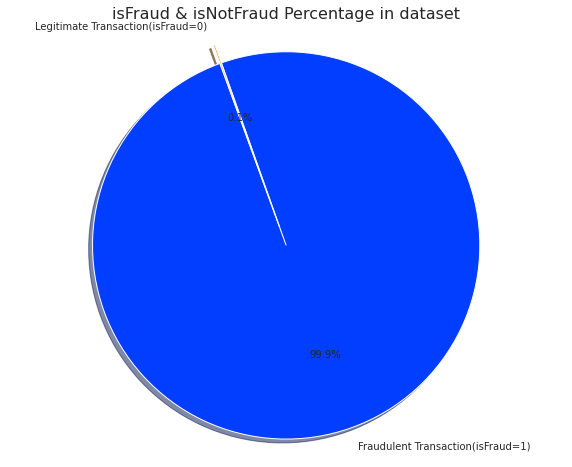

In [39]:
ratio = df.groupby(['isFraud']).size()
print(f"Percentages of Fraudulent and Legitimate Transactions: {ratio}")
labels = ['Fraudulent Transaction(isFraud=1)','Legitimate Transaction(isFraud=0)']
explode = (0.1, 0)  # only "explode" the 1st slice

plt.figure(figsize=(10, 8))
plt.pie(
    ratio, 
    labels = labels, 
    colors = sns.color_palette('bright'), 
    #autopct = '%.0f%%',
    autopct = '%1.1f%%',
    explode = explode, 
    shadow = True, 
    startangle = 110
)
plt.title('isFraud & isNotFraud Percentage in dataset', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

The dataset is extremely skewed, given that just 0.1% of the data indicates fraudulent transactions. To provide accurate modelling results, it will need to be balanced.

One solution to this problem is to resample the dataset using Undersampling or Oversampling techniques.

['TRANSFER', 'CASH OUT'] are examples of fraudulent transaction types.

A total of 4097 fraudulent 'TRANSFERS' were made.

4116 fraudulent 'CASH_OUT's were recorded.

In [40]:
one_hot = pd.get_dummies(df['type'])
df = df.join(one_hot)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,errorBalanceOrg,errorBalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,-1.0,-1.0,0,0,0.0,9839.64,0,0,0,1,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,-1.0,-1.0,0,0,0.0,1864.28,0,0,0,1,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,-1.0,-1.0,1,0,0.0,181.00,0,0,0,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0.0,-21001.00,0,1,0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,-1.0,-1.0,0,0,0.0,11668.14,0,0,0,1,0


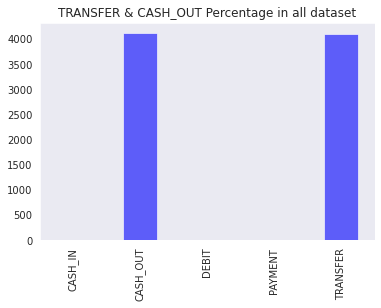

In [41]:
type_fraud_df = df[df['isFraud'] == 1][['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT','TRANSFER']].sum()

plt.ticklabel_format(style = 'plain')
type_fraud_df.plot(kind='bar', color='blue', alpha=0.6)
plt.title('TRANSFER & CASH_OUT Percentage in all dataset')
plt.show()

In [42]:
df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud', 'type'], axis=1, inplace=True)

After encoding categorical characteristics, oversampling is performed using the SMOTE technique.

In [43]:
from imblearn.over_sampling import SMOTE
from collections import Counter

X = df.drop('isFraud', axis=1)
y = df.isFraud
X_data, Y_data = SMOTE().fit_resample(X, y)
Counter(Y_data)

Counter({0: 6354407, 1: 6354407})

In [44]:
upsampled_df = X_data.copy() 
upsampled_df['isFraud'] = Y_data
upsampled_df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,errorBalanceOrg,errorBalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,isFraud
0,1,9839.64,170136.0,160296.36,-1.0,-1.0,0.0,9839.64,0,0,0,1,0,0
1,1,1864.28,21249.0,19384.72,-1.0,-1.0,0.0,1864.28,0,0,0,1,0,0
2,1,181.00,181.0,0.00,-1.0,-1.0,0.0,181.00,0,0,0,0,1,1
3,1,181.00,181.0,0.00,21182.0,0.0,0.0,-21001.00,0,1,0,0,0,1
4,1,11668.14,41554.0,29885.86,-1.0,-1.0,0.0,11668.14,0,0,0,1,0,0


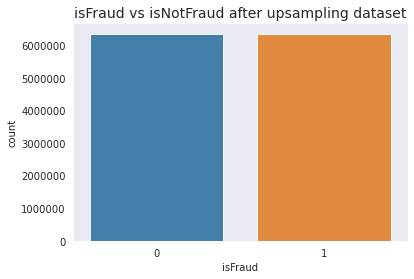

In [45]:
plt.ticklabel_format(style = 'plain')
sns.countplot(x=Y_data, alpha=0.9);
plt.title('isFraud vs isNotFraud after upsampling dataset', fontsize=14);

In [46]:
# Undersampling by selecting a sample size of non-fraud items equal to the length of the fraud items.
fraud_df = df[df['isFraud'] == 1]
non_fraud_df = df[df['isFraud'] == 0]

non_fraud_df = non_fraud_df.sample(n=len(fraud_df))
undersampled_df = pd.concat([fraud_df, non_fraud_df])
undersampled_df = undersampled_df.sample(frac=1)

undersampled_df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errorBalanceOrg,errorBalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
1853440,164,175267.61,175267.61,0.00,73374.37,248641.98,1,0.00,3.505352e+05,0,1,0,0,0
3571728,261,13555.24,52.00,0.00,-1.00,-1.00,0,13503.24,1.355524e+04,0,0,0,1,0
2116097,183,4354175.33,4354175.33,0.00,-1.00,-1.00,1,0.00,4.354175e+06,0,0,0,0,1
5804393,401,263672.57,0.00,0.00,621666.02,885338.59,0,263672.57,5.273451e+05,0,1,0,0,0
5965893,406,144494.63,13602306.48,13746801.11,18350820.17,18206325.54,0,288989.26,-3.725290e-09,1,0,0,0,0


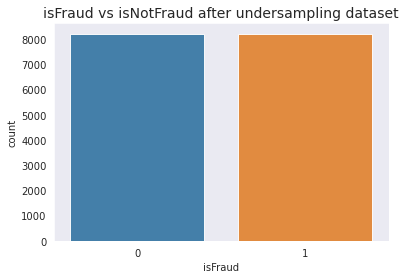

In [47]:
sns.countplot(x=undersampled_df.isFraud, alpha=0.9);
plt.title('isFraud vs isNotFraud after undersampling dataset', fontsize=14);

In [48]:
#df = upsampled_df.copy()
df = undersampled_df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16426 entries, 1853440 to 3695546
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   step              16426 non-null  int64  
 1   amount            16426 non-null  float64
 2   oldbalanceOrg     16426 non-null  float64
 3   newbalanceOrig    16426 non-null  float64
 4   oldbalanceDest    16426 non-null  float64
 5   newbalanceDest    16426 non-null  float64
 6   isFraud           16426 non-null  int64  
 7   errorBalanceOrg   16426 non-null  float64
 8   errorBalanceDest  16426 non-null  float64
 9   CASH_IN           16426 non-null  uint8  
 10  CASH_OUT          16426 non-null  uint8  
 11  DEBIT             16426 non-null  uint8  
 12  PAYMENT           16426 non-null  uint8  
 13  TRANSFER          16426 non-null  uint8  
dtypes: float64(7), int64(2), uint8(5)
memory usage: 1.8 MB


In [49]:
df

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errorBalanceOrg,errorBalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
1853440,164,175267.61,175267.61,0.00,73374.37,248641.98,1,0.00,3.505352e+05,0,1,0,0,0
3571728,261,13555.24,52.00,0.00,-1.00,-1.00,0,13503.24,1.355524e+04,0,0,0,1,0
2116097,183,4354175.33,4354175.33,0.00,-1.00,-1.00,1,0.00,4.354175e+06,0,0,0,0,1
5804393,401,263672.57,0.00,0.00,621666.02,885338.59,0,263672.57,5.273451e+05,0,1,0,0,0
5965893,406,144494.63,13602306.48,13746801.11,18350820.17,18206325.54,0,288989.26,-3.725290e-09,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3748276,279,2670.80,0.00,0.00,-1.00,-1.00,0,2670.80,2.670800e+03,0,0,0,1,0
4341079,308,45774.52,93467.70,47693.18,103679.50,149454.02,0,0.00,9.154904e+04,0,1,0,0,0
1954768,178,158192.07,6210550.82,6368742.88,1566682.82,1408490.75,0,316384.13,0.000000e+00,1,0,0,0,0
2382160,198,152961.49,152961.49,0.00,-1.00,-1.00,1,0.00,1.529615e+05,0,0,0,0,1


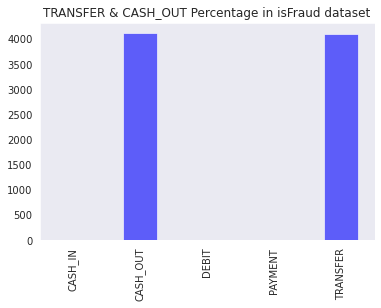

In [50]:
type_fraud_df = df[df.isFraud==1][['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT','TRANSFER']].sum()
type_fraud_df.plot(kind='bar', color='blue', alpha=0.6)
plt.title('TRANSFER & CASH_OUT Percentage in isFraud dataset')
plt.show()

##  Feature Distribution

In [51]:
columns = ['amount', 'oldbalanceOrg', 'newbalanceOrig',
 'oldbalanceDest', 'newbalanceDest', 'errorBalanceOrg', 'errorBalanceDest']

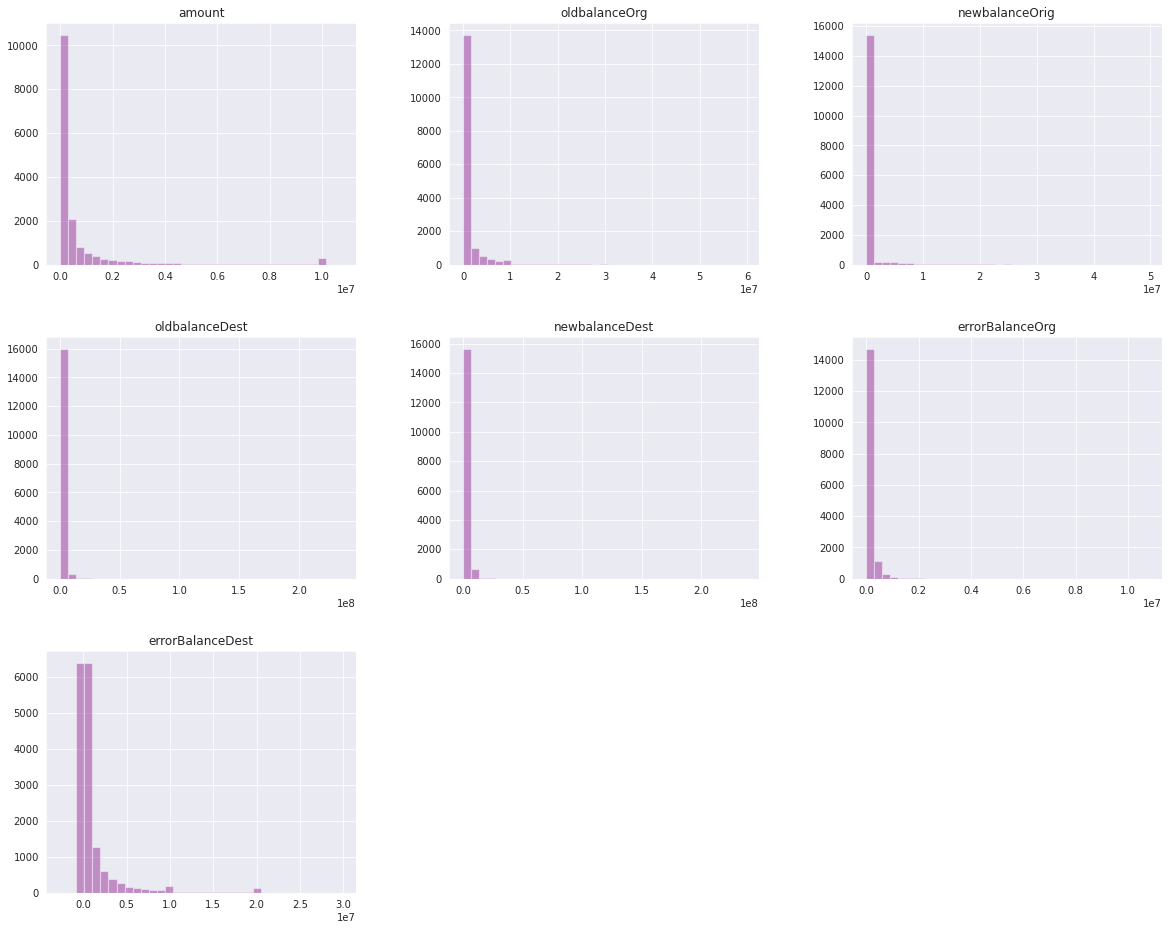

In [52]:
df.drop('isFraud', axis=1)[columns].hist(
    #edgecolor = 'black', 
    bins = 35,
    linewidth = 1.2, 
    figsize = (20, 16), 
    color = 'Purple', 
    alpha = 0.4
);

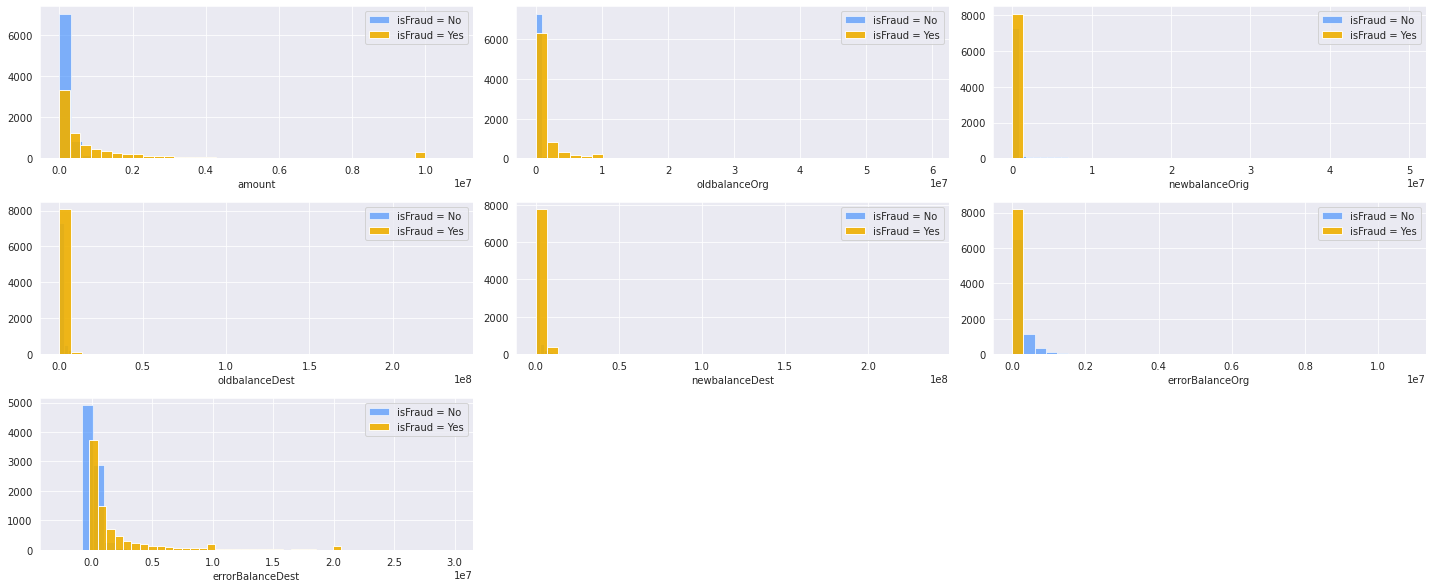

In [53]:
rows, cols = 6, 3

fig = plt.figure(figsize=(20, 16))
for index, column in enumerate(columns, 1):
    ax = fig.add_subplot(rows, cols, index)
    df[df["isFraud"] == 0][column].hist(bins=35, label='isFraud = No', color="#3386FF", alpha=0.6)
    df[df["isFraud"] == 1][column].hist(bins=35, label='isFraud = Yes', color="#EFB000", alpha=0.9)
    ax.set_xlabel(column)    
    ax.legend()
fig.tight_layout()    

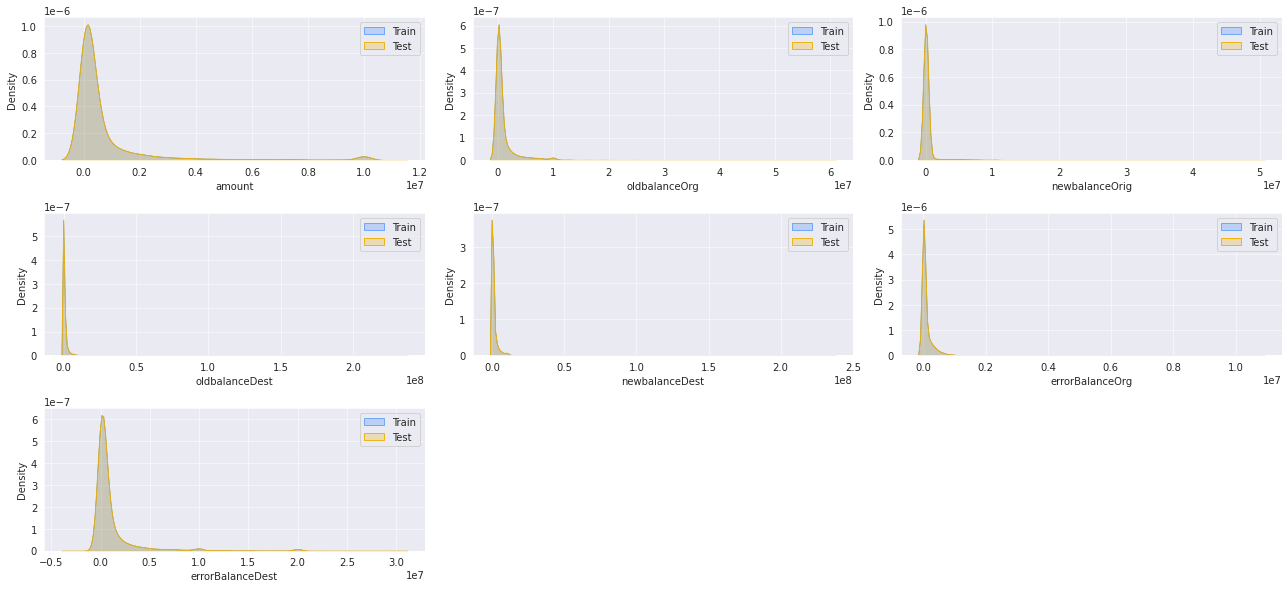

In [54]:
fig = plt.figure(figsize=(18, 16))

for idx, feature in enumerate(columns, 1):
    ax = fig.add_subplot(rows, cols, idx)
    ax.grid(alpha = 0.7, axis ="both")
    sns.kdeplot(x = feature, fill = True,color = "#3386FF", linewidth=0.6, data = df, label = "Train")
    sns.kdeplot(x = feature, fill = True,color = "#EFB000", linewidth=0.9, data = df, label = "Test")      
    ax.set_xlabel(feature)
    ax.legend()
fig.tight_layout()

## Boxplot (Detecting Outliers)

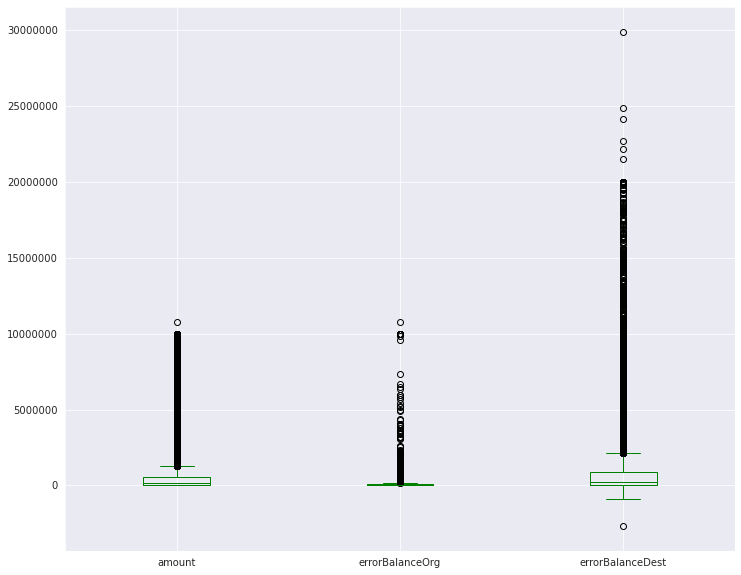

In [55]:
plt.rcParams['figure.figsize'] = (12, 10)
plt.ticklabel_format(style = 'plain')
df.boxplot(column=['amount', 'errorBalanceOrg', 'errorBalanceDest'], grid='true', color='g',fontsize=10);

###  Remove Outliers and re-plot the Boxplot

In [56]:
def remove_outlier(df_in, col_name, q=0.75):
    q1 = df_in[col_name].quantile(1-q)
    q3 = df_in[col_name].quantile(q)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

df2 = remove_outlier(df, 'amount')

Check the Boxplot after removing the major outliers.

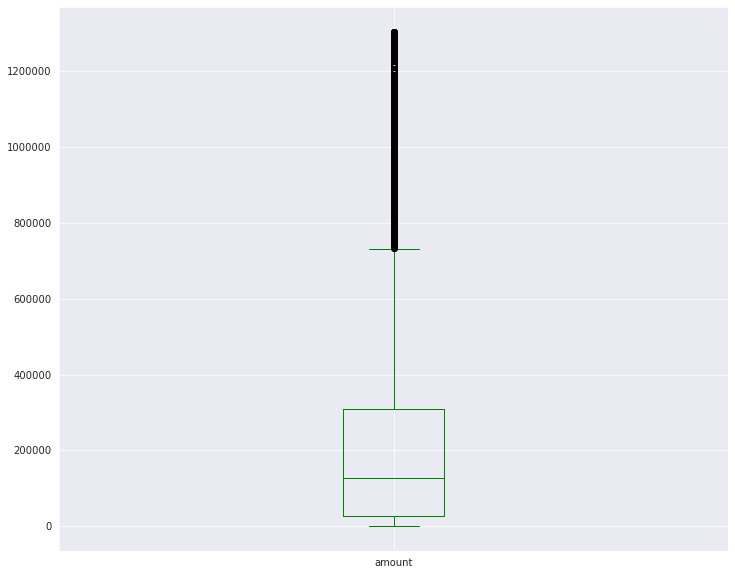

In [57]:
plt.rcParams['figure.figsize'] = (12, 10)
plt.ticklabel_format(style = 'plain')
df2.boxplot(column=['amount'], grid='true', color='g',fontsize=10);

## Correlation Analysis


The linear link between two or more variables is measured via correlation. We can predict one variable from the other using correlation. The reasoning for using correlation for feature selection is that useful variables have a strong correlation with the target. Furthermore, variables should be relevant to the aim yet uncorrelated to one another.

We can predict one variable from the other if they are correlated. As a result, if two features are correlated, the model only requires one because the second provides no additional information.

In [58]:
df_corr = df.corr()
#plt.figure(figsize=(20, 20));
#sns.heatmap(df_corr, annot=True);
df_corr.style.background_gradient(cmap='YlGn') # coolwarm YlGn BuGn

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errorBalanceOrg,errorBalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
step,1.000000,0.150483,0.082406,-0.011715,-0.003534,0.032223,0.322492,-0.057829,0.135782,-0.105052,0.043947,-0.004685,-0.147847,0.147048
amount,0.150483,1.000000,0.649928,0.126289,-0.011610,0.254021,0.350416,0.089900,0.937333,-0.122707,0.051588,-0.026316,-0.198858,0.195833
oldbalanceOrg,0.082406,0.649928,1.000000,0.827223,0.008748,0.127175,0.128243,0.046559,0.546084,0.244145,-0.092112,-0.020760,-0.160442,0.068266
newbalanceOrig,-0.011715,0.126289,0.827223,1.000000,0.039931,0.005077,-0.126310,0.146245,0.041216,0.438516,-0.171110,-0.010105,-0.080356,-0.046613
oldbalanceDest,-0.003534,-0.011610,0.008748,0.039931,1.000000,0.919813,-0.084004,0.133153,0.015135,0.069058,0.122497,0.009670,-0.114899,-0.086504
newbalanceDest,0.032223,0.254021,0.127175,0.005077,0.919813,1.000000,0.011415,0.168324,0.362739,0.008047,0.235220,0.001438,-0.157495,-0.130828
isFraud,0.322492,0.350416,0.128243,-0.126310,-0.084004,0.011415,1.000000,-0.245049,0.321785,-0.349606,0.156837,-0.059527,-0.453895,0.452075
errorBalanceOrg,-0.057829,0.089900,0.046559,0.146245,0.133153,0.168324,-0.245049,1.000000,0.113722,0.221039,-0.095361,-0.015924,-0.116227,0.050418
errorBalanceDest,0.135782,0.937333,0.546084,0.041216,0.015135,0.362739,0.321785,0.113722,1.000000,-0.141093,0.181751,-0.025046,-0.188020,0.057985
CASH_IN,-0.105052,-0.122707,0.244145,0.438516,0.069058,0.008047,-0.349606,0.221039,-0.141093,1.000000,-0.299741,-0.020811,-0.158684,-0.225102


In [59]:
corr_column = 'isFraud Correlation'
df_corrwith = df.drop('isFraud', axis=1)\
    .corrwith(df.isFraud)\
    .to_frame(name=corr_column)\
    .sort_values(by=corr_column, ascending=False)

df_corrwith.style.background_gradient(cmap='YlGn')

,isFraud Correlation
TRANSFER,0.452075
amount,0.350416
step,0.322492
errorBalanceDest,0.321785
CASH_OUT,0.156837
oldbalanceOrg,0.128243
newbalanceDest,0.011415
DEBIT,-0.059527
oldbalanceDest,-0.084004
newbalanceOrig,-0.126310


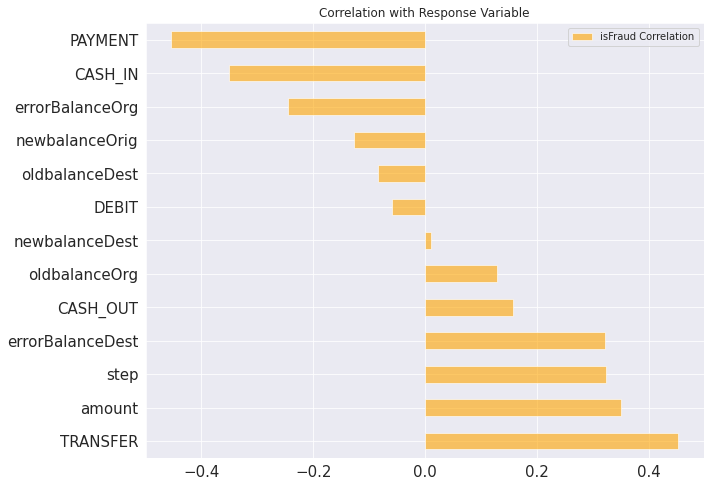

In [60]:
df_corrwith.plot.barh(
    #edgecolor='black',
    figsize = (10, 8), 
    title = 'Correlation with Response Variable',
    fontsize = 15, 
    grid = True,
    color = 'Orange',
    alpha = 0.6
);

    Features with a **negative correlation** mean that the lower those values, the more probable the user is to be a fraudster. Features with **positive correlation** mean that the greater the rise in those parameters, the less likely the user is to be fraudulent. 
    
    The graph's most important observation is that CASH IN and PAYMENT are negatively correlated with isFraud. This means that various types of fraud are unlikely to occur.

    TRANSFER and diffbalanceOrg have a positive relationship with isFraud. That means that this form of fraud is very likely to occur. 
    
    It should be noted that, while the fields are slightly correlated, they are not co-linear. These features are not functions of each other, thus they will not break the model, but they will also not assist much. They should be removed by Feature Selection.

Split dataset to train/test datasets.

After encoding categorical characteristics, **oversampling** is performed using the SMOTE technique.

In [61]:
X = df.loc[:, df.columns != 'isFraud']
y = df.isFraud
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.5,random_state =123)
feature_names = X_train.columns

**Feature importance** techniques provide a score to input characteristics based on their usefulness in predicting a target variable.

### Feature importance based on Mutual information

**Mutual information (MI)** between two random variables is a non-negative number that measures the variables' dependence. It is equal to zero when two random variables are independent, while higher values indicate greater dependency.

Elapsed time to compute the importances: 0.930 seconds


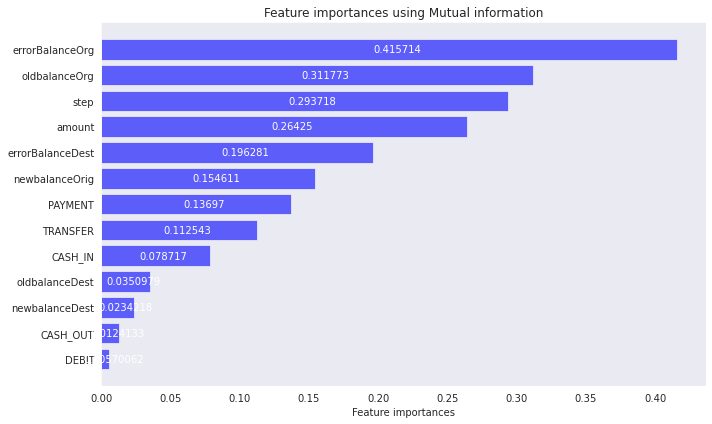

(array([10,  9,  5,  4,  8, 12, 11,  3,  7,  1,  0,  2,  6]),
 array([0.29371764, 0.26424952, 0.31177284, 0.15461052, 0.03509795,
        0.02342183, 0.41571444, 0.19628064, 0.07871703, 0.01241332,
        0.00570062, 0.13697018, 0.1125426 ]))

In [62]:
from sklearn.feature_selection import mutual_info_classif

def feature_importances_using_MI(X, y):
    """
    input: plot and return the feature importance using Mutual information
    """
    features = list(X.columns)
    start_time = time.time()
    importances = mutual_info_classif(X, y, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)
    indices = np.argsort(importances)
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
    
    plt.figure(figsize=(10, 6))
    plt.title("Feature importances using Mutual information")
    bars = plt.barh(range(len(indices)), importances[indices], color="b", align="center", alpha=0.6)
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel("Feature importances")
    plt.bar_label(bars, label_type='center', padding=8, color='w')
    plt.tight_layout()    
    plt.show()
    return indices, importances

feature_importances_using_MI(X, y)

### Feature importance based on mean decrease in impurity

The numerical features are ranked in order of relevance depending on their impurity. As a result, one of the most important features is the non-predictive random num variable!

Elapsed time to compute the importances: 0.009 seconds


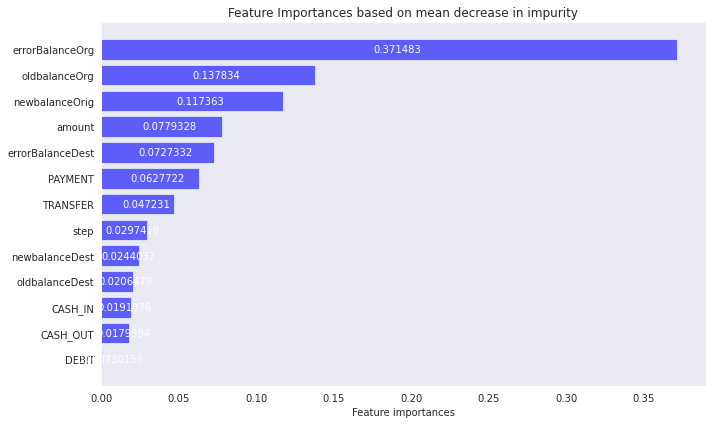

(array([10,  9,  8,  4,  5,  0, 12, 11,  7,  1,  3,  2,  6]),
 array([0.02974194, 0.07793282, 0.13783437, 0.11736309, 0.02064795,
        0.02440374, 0.37148255, 0.07273321, 0.0191876 , 0.01793938,
        0.00073016, 0.06277216, 0.04723104]))

In [63]:
def feature_importances_using_MDI(X, y):
    """
    input:  features and target
    output: return and plot the feature importance based on mean decrease in impurity
    """
    model = RandomForestClassifier(random_state=0)
    model.fit(X, y)
    features = list(X.columns)
    start_time = time.time()
    importances = model.feature_importances_
    indices = np.argsort(importances)
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
    
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances based on mean decrease in impurity")
    bars = plt.barh(range(len(indices)), importances[indices], color="b", align="center", alpha=0.6)
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel("Feature importances")
    plt.bar_label(bars, label_type='center', padding=8, color='w')
    plt.tight_layout()    
    plt.show()
    return indices, importances

feature_importances_using_MDI(X, y)

### Feature importance based on feature permutation

If I randomly shuffle a single column of the validation data, leaving the target and all other columns in place, how would that affect the accuracy of predictions in that now-shuffled data?

Elapsed time to compute the importances: 8.224 seconds


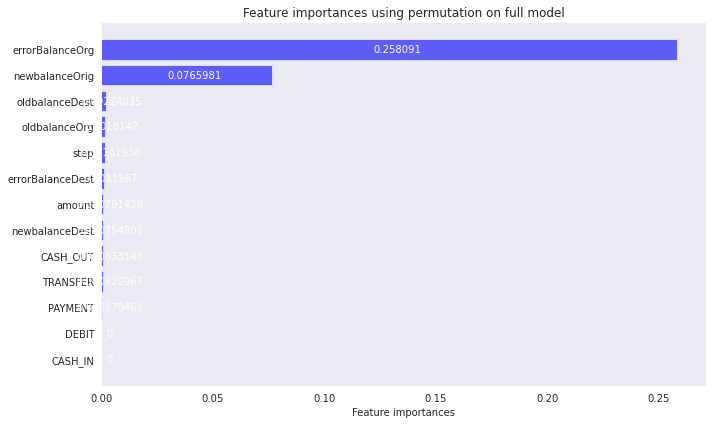

(array([ 8, 10, 11, 12,  9,  5,  1,  7,  0,  2,  4,  3,  6]),
 array([1.61938390e-03, 7.91428224e-04, 1.81419700e-03, 7.65980762e-02,
        2.24035066e-03, 7.54900767e-04, 2.58090832e-01, 1.15670279e-03,
        0.00000000e+00, 6.33142579e-04, 0.00000000e+00, 1.70461464e-04,
        6.20966760e-04]))

In [64]:
from sklearn.inspection import permutation_importance


def feature_importances_using_feature_permutation(X, y):
    """
    input:  features and target
    output: return and plot the feature importance based on feature permutation
    """
    model = RandomForestClassifier(random_state=0)
    model.fit(X, y)
    features = list(X.columns)
    start_time = time.time()
    importances = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2).importances_mean
    elapsed_time = time.time() - start_time
    indices = np.argsort(importances)
    print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

    plt.figure(figsize=(10, 6))
    plt.title("Feature importances using permutation on full model")
    bars = plt.barh(range(len(indices)), importances[indices], color="b", align="center", alpha=0.6)
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel("Feature importances")
    plt.bar_label(bars, label_type='center', padding=8, color='w')
    plt.tight_layout()    
    plt.show()
    return indices, importances

feature_importances_using_feature_permutation(X, y)

In [65]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,1.00,1.00,1.00,1.00,0.28
XGBClassifier,1.00,1.00,1.00,1.00,1.48
RandomForestClassifier,1.00,1.00,1.00,1.00,0.93
AdaBoostClassifier,1.00,1.00,1.00,1.00,0.60
BaggingClassifier,1.00,1.00,1.00,1.00,0.22
DecisionTreeClassifier,1.00,1.00,1.00,1.00,0.11
ExtraTreesClassifier,1.00,1.00,1.00,1.00,0.62
ExtraTreeClassifier,0.98,0.98,0.98,0.98,0.03
KNeighborsClassifier,0.96,0.96,0.96,0.96,0.49


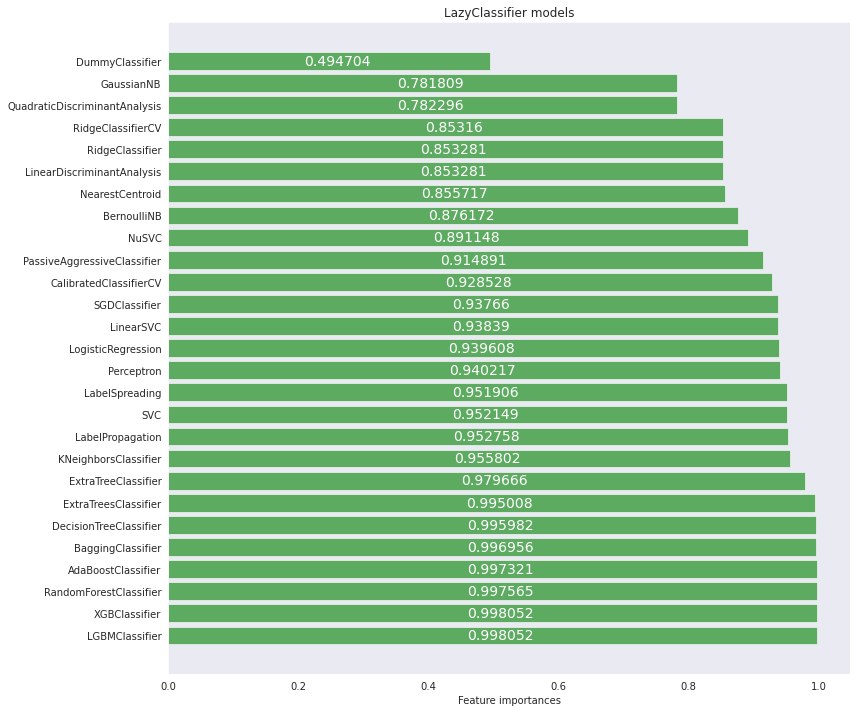

In [66]:
plt.figure(figsize=(12, 10))
plt.title("LazyClassifier models")
bars = plt.barh(list(models.index), models.Accuracy, color="g", align="center", alpha=0.6)
plt.yticks(range(len(models.index)), list(models.index))
plt.xlabel("Feature importances")
plt.tight_layout()    
plt.bar_label(bars, label_type='center', padding=8, color='w', fontsize=14)
plt.show()